In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OrdinalEncoder

In [2]:
import keras 

from keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU
from keras.layers import Embedding
from keras.layers import Concatenate, Flatten, Reshape, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.utils import plot_model
from keras import backend as K

from keras.datasets import imdb

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Helpful links:
1. Inverse of np.log1p: https://stackoverflow.com/questions/50049891/what-is-the-inverse-of-numpys-log1p
2. Building parallel keras model: https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras
3. How to make parallel keras models: https://datascience.stackexchange.com/questions/39407/how-to-make-two-parallel-convolutional-neural-networks-in-keras
4. 2 parallel keras layers: https://stackoverflow.com/questions/51546075/two-parallel-conv2d-layers-keras
5. Setting up Conv1D and LSTM: https://stackoverflow.com/questions/51344610/how-to-setup-1d-convolution-and-lstm-in-keras
6. Take average of LSTM hidden states using Lambda: https://stackoverflow.com/questions/51479940/average-channels-of-convolutional-layer-keras
7. Preparing categorical variable for neural networks: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
8. Tutorial for using keras for time series (no generators used): https://medium.com/@jdwittenauer/deep-learning-with-keras-structured-time-series-37a66c6aeb28


In [4]:
train = pd.read_csv("gs://123test_bucket/train.csv")

In [5]:
reading = train['meter_reading']
train['meter_reading'] = np.log1p(train['meter_reading'])
train['meter_reading'] = sklearn.preprocessing.normalize(np.reshape(train['meter_reading'].values, (-1, 1))).reshape(len(train),)

In [6]:
train.timestamp = pd.to_datetime(train.timestamp)

In [7]:
train['month'] = train.timestamp.dt.month
train['dayofweek'] = train.timestamp.dt.dayofweek
train['hour'] = train.timestamp.dt.hour

In [8]:
len(train)

20216100

Using 30% of the data as validation data. If more data is needed, we should consider adding data by randomly selecting buildings.

In [9]:
ids = train['building_id'].unique()

In [10]:
# keeping only 5% of the ids
len_sub = round(len(ids)*0.05)
ids_sub = np.random.choice(ids, len_sub, replace = False)

In [11]:
# 0.3 represents the percentage of data that is kept for validation
len_val = round(len(ids_sub)*0.3)

In [12]:
ids_val = np.random.choice(ids_sub, len_val, replace = False)

In [13]:
ids_train = np.setdiff1d(ids_sub,ids_val)

In [14]:
assert len(ids_val)+len(ids_train)==len(ids_sub)

#### Scaling by np.log1p

In [15]:
#train['meter_reading'] = np.log1p(train['meter_reading'])

#### Applying TimeseriesGenerator to the ASHRAE training data

Once difference between the example above, and our situation is that we have multiple timeseries, for each building and each meter in the building. So, we will be required to modify the code a little bit.

Below, we check how many meters exist in the dataset.

In [16]:
len(train[['building_id', 'meter']].drop_duplicates())

2380

The code below has been taken from this stackoverflow answer with some modifications:
https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459

The modification is basically that once we subset the data for building ID, it is then subset for meter type also.

Further reading about modifying keras generator classes can be found below:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [17]:
col_names = ['building_id', 'meter', 'hour', 'dayofweek', 'month']
enc = OrdinalEncoder()
enc.fit(train[col_names])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [18]:
# https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459
# https://keras.io/preprocessing/sequence/
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs/49405175
# https://medium.com/datadriveninvestor/keras-training-on-large-datasets-3e9d9dbc09d4
class TSDataGenerator(keras.utils.Sequence):
    def __init__(self, dt, length = 168, batch_size = 10):
        self.tgs = list()
        self.count = 0 # counter: for verifying the length
        # counting batches this way is needed for calculating
        # batches for categorical data
        
        # for each building_id, and meter create batches of time series
        for i in range(dt['building_id'].min(),dt['building_id'].max()+1):
            sub = dt.loc[dt['building_id'] == i, ['meter', 'meter_reading']]
            
            for meter in sub['meter'].unique():
                # subsetting for meter type
                adf = sub.loc[sub['meter'] == meter, 'meter_reading'].values
                # the data needs to be reformatted so that it fits the neural 
                # network model properly
                adf = np.reshape(adf, (len(adf),1))
                
                # adding the timeseriesgenerator to a list of batches
                self.tgs.append(TimeseriesGenerator(adf,adf,length,batch_size=batch_size))
                
                # calculating length
                l = np.ceil((len(adf) - length)/batch_size)              
                self.count = self.count+l             

        self.len = sum([len(tg) for tg in self.tgs])
        self.idx_i = list()
        self.idx_j = list()

        for i, tg in enumerate(self.tgs):
            self.idx_i.extend(list(range(len(tg))))
            self.idx_j.extend([i]*len(tg))    
        #print ( self.idx_i,  self.idx_j)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.tgs[self.idx_j[index]][self.idx_i[index]]



In [19]:
class CatDataGenerator(keras.utils.Sequence):
    def __init__(self, dt, length = 168, batch_size = 10):
        self.batch_size = batch_size
        self.tgs = list()
        self.count = 0
        col_names = ['building_id', 'meter', 'hour', 'dayofweek', 'month']
        for i in range(dt['building_id'].min(),dt['building_id'].max()+1):
            sub = dt.loc[dt['building_id'] == i, col_names]
            for meter in sub['meter'].unique():
                # subsetting the building_id, and meter
                adf = sub.loc[sub['meter'] == meter, col_names].copy().reset_index(drop=True)
                # number of columns
                cols = len(adf.columns)
                
                # Encoding categorical data
                tm = enc.transform(adf[col_names])
                tm_short = tm[length:]
                
                # How many batches 
                l = np.ceil((len(adf) - length)/batch_size)
                self.count = self.count+l
                l = int(l)

                for j in range(l):
                    # correctly indexing the series,
                    # this ensures the length is correct
                    index_start = j*batch_size
                    index_end = index_start+batch_size
                    cat = tm_short[index_start:index_end] 
                    
                    # we select the value after the index_end,
                    # corresponding to y.
                    #val = tm[(index_end+1)] 
                    size = len(cat)
                    #print(val)
                    # reshaping the data
                    x = cat#.reshape((size,1))
                    y = np.zeros((size,1))
                    self.tgs.append((x,y))
                
        self.len = self.count
        self.idx_i = list()
        self.idx_j = list()

        for i, tg in enumerate(self.tgs):
            self.idx_i.extend(list(range(len(tg))))
            self.idx_j.extend([i]*len(tg))    
        
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.tgs[index]

In [20]:
class MultipleInputGenerator(keras.utils.Sequence):
    def __init__(self, dt, length = 168, batch_size = 10):
        self.train1_gen = TSDataGenerator(dt,length, batch_size = batch_size)
        self.train2_gen = CatDataGenerator(dt,length, batch_size = batch_size)

    def __len__(self):
        """It is mandatory to implement it on Keras Sequence"""
        if self.train1_gen.__len__() == self.train2_gen.__len__():
            return self.train1_gen.__len__()

    def __getitem__(self, index):
        """Getting items from the 2 generators and packing them"""
        X1_batch, Y1_batch = self.train1_gen.__getitem__(index)
        X2_batch, Y2_batch = self.train2_gen.__getitem__(index)

        X_batch = [X1_batch, X2_batch]

        return X_batch, Y1_batch    

Based on a manual check it was found that there were 12 unique meters in the train_sub dataset.

In our case we want to use 24*7 timesteps, representing 7 days and 24 hours. We can experiment with the batch size but using 20 here for a short example.

#### Training and Validation Generators

In [21]:
# Test
length = 24*7
batch_size = 1024#1024+512
train_gen = MultipleInputGenerator(train[train['building_id'].isin(ids_train)],length, batch_size = batch_size)
val_gen = MultipleInputGenerator(train[train['building_id'].isin(ids_val)],length, batch_size = batch_size)   


In [22]:
# Checking the row counts match
check = list()
for i in range(len(train_gen)):
    check.append((train_gen[i][0][1][0][0],train_gen[i][0][1][0][1], train_gen[i][0][0].shape[0]))
    if not train_gen[i][0][0].shape[0]==train_gen[i][0][1].shape[0]==train_gen[i][1].shape[0]:
        print(train_gen[i][0][0].shape[0],train_gen[i][0][1].shape[0],train_gen[i][1].shape[0], 
              i, train_gen[i][0][1][0])


In [23]:
check = train_gen[0]
print(check[0][0].shape, check[0][1].shape, check[1].shape)

(1024, 168, 1) (1024, 5) (1024, 1)


In [24]:
sub = train[(train['building_id'] == 5) & (train['meter'] == 0) ]

In [25]:
sub[length:(length+batch_size)]

,building_id,meter,timestamp,meter_reading,month,dayofweek,hour
386012,5,0,2016-01-08 00:00:00,0.0,1,4,0
388305,5,0,2016-01-08 01:00:00,0.0,1,4,1
390597,5,0,2016-01-08 02:00:00,0.0,1,4,2
392891,5,0,2016-01-08 03:00:00,0.0,1,4,3
395188,5,0,2016-01-08 04:00:00,0.0,1,4,4
...,...,...,...,...,...,...,...
2678421,5,0,2016-02-19 11:00:00,0.0,2,4,11
2680488,5,0,2016-02-19 12:00:00,0.0,2,4,12
2682557,5,0,2016-02-19 13:00:00,0.0,2,4,13
2684626,5,0,2016-02-19 14:00:00,0.0,2,4,14


#### Loss Function - Root Mean Square

In [26]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [27]:
(batch_size,1,length)

(1024, 1, 168)

#### CNN 1-D + LSTM


In [63]:
#model = Sequential()
filters = 10
ncols = len(col_names) # categorical columns
states = 24
input_shape1 = Input(shape=(length,1))
input_shape2 = Input(shape=(ncols,))

m1 = Conv1D(filters=filters, kernel_size=7, activation='relu')(input_shape1)
m1 = MaxPooling1D(pool_size=2, strides=2)(m1)

#m2 = Conv1D(filters=filters, kernel_size=5, activation='relu')(input_shape1)
#m2 = MaxPooling1D(pool_size=2, strides=2)(m2)

#m3 = Conv1D(filters=filters, kernel_size=7, activation='relu')(input_shape1)
#m3 = MaxPooling1D(pool_size=2, strides=2)(m3)

#m = keras.layers.concatenate([m1, m2, m3], axis = 1)
#m = Reshape((246,filters))(m)
m_a = LSTM(states, return_sequences=True)(m1)
m_a = Lambda(lambda x: keras.backend.mean(x, axis=2))(m_a)
m_a = Model(inputs=input_shape1, outputs=m_a)

#m_b = Dense(2, activation='relu')(input_shape2)
#m_b = Model(inputs=input_shape2, outputs=m_b)

#combined = keras.layers.concatenate([m_a.output, m_b.output])
combined = keras.layers.concatenate([m_a.output, input_shape2])

out = Dense(states, activation='relu')(combined)
out = Dense(1, activation='relu')(out)

model = Model(inputs = [input_shape1, input_shape2], outputs = out)

In [64]:
model.compile(loss=root_mean_squared_error, optimizer='rmsprop', metrics=['mse', 'mae', 'mape'])

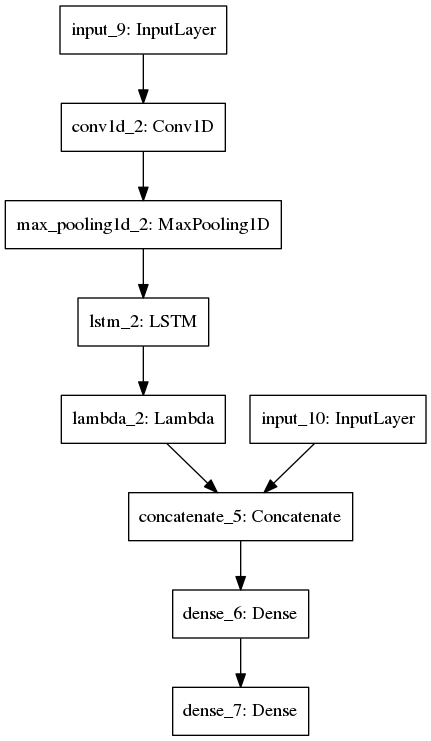

In [65]:
plot_model(model)

In [66]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 168, 1)       0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 162, 10)      80          input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 81, 10)       0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 81, 24)       3360        max_pooling1d_2[0][0]            
____________________________________________________________________________________________

In [32]:
# Train model on dataset
model.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=5,
                    use_multiprocessing=True,
                    workers=12, verbose =2)
# Add input for building id, and join it with lamda output

Epoch 1/5
 - 519s - loss: nan - mse: nan - mae: nan - mape: nan - val_loss: nan - val_mse: nan - val_mae: nan - val_mape: nan
Epoch 2/5


Process ForkPoolWorker-41:
Process ForkPoolWorker-43:
Process ForkPoolWorker-44:
Process ForkPoolWorker-38:
Process ForkPoolWorker-45:
Process ForkPoolWorker-35:
Process ForkPoolWorker-29:
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-48:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-27:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-30:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-42:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 24

KeyboardInterrupt: 

### Dense NN

In [36]:
#model = Sequential()
filters = 10
ncols = len(col_names) # categorical columns
states = 20
act = 'linear'

input_shape1 = Input(shape=(length,1))
input_shape2 = Input(shape=(ncols,))

n_a = LSTM(states, return_sequences=True)(input_shape1)
n_a = Lambda(lambda x: keras.backend.mean(x, axis=2))(n_a)
n_a = Model(inputs=input_shape1, outputs=n_a)

n1 = Dense(5, activation=act)(input_shape2)
n1 = Model(inputs=input_shape2, output=n1)

combined2 = keras.layers.concatenate([n_a.output, n1.output])
out2 = Dense(states, activation=act)(combined2)#Dense(states, activation=act)(combined2)
out2 = LeakyReLU(alpha=0.1)(out2)
out2 = Dropout(0.2)(out2)
out2 = Dense(1)(out2)#Dense(1, activation=act)(out2)

model2 = Model(inputs = [input_shape1, input_shape2], outputs = out2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [37]:
opt = keras.optimizers.RMSprop(clipnorm=1.)

model2.compile(loss=root_mean_squared_error, optimizer=opt, metrics=['mse', 'mae', 'mape'])

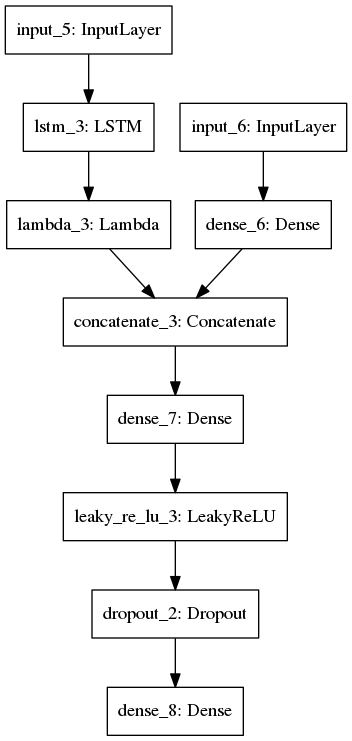

In [38]:
plot_model(model2)

In [39]:
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 168, 1)       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 168, 20)      1760        input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 168)          0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [40]:
max(train['meter_reading'])

1.0

In [ ]:
# Train model on dataset
model2.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=5,
                    use_multiprocessing=True, workers = 16)

Epoch 1/5
562/562 [==============================] - 151s 268ms/step - loss: 1.9469 - mse: 24.2225 - mae: 1.5150 - mape: 52208720.0000 - val_loss: 0.7137 - val_mse: 0.2925 - val_mae: 0.4788 - val_mape: 72797576.0000
Epoch 2/5
 37/562 [>.............................] - ETA: 1:52 - loss: 0.4470 - mse: 0.3939 - mae: 0.4115 - mape: 8997925.0000